<a href="https://colab.research.google.com/github/danieljai/CIND820-AndyLee/blob/main/AndyLee_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 3: Preload setup

Basic setup so results can utilize the full width of the screen.

In [1]:
%config IPCompleter.greedy=True
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

# Step 4: Import Dataset

The hydrated file is stored in a Google Drive, and using the follow code will mount Google Drive onto Colaboratory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/My Drive/__CIND 820 - Data Analytics Project/3-data/Book1-fastsave.csv")

# Step 5. Data Cleaning and Manipulation

## Preview data after cleaning and manipulation

Original Tweet dataframe datatypes

In [4]:
# https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/user-object
df.dtypes

coordinates                    object
created_at                     object
hashtags                       object
media                          object
urls                           object
favorite_count                  int64
id                              int64
in_reply_to_screen_name        object
in_reply_to_status_id         float64
in_reply_to_user_id           float64
lang                           object
place                          object
possibly_sensitive             object
retweet_count                   int64
retweet_id                    float64
retweet_screen_name            object
source                         object
text                           object
tweet_url                      object
user_created_at                object
user_screen_name               object
user_default_profile_image       bool
user_description               object
user_favourites_count           int64
user_followers_count            int64
user_friends_count              int64
user_listed_

## Readjust attribute datatype

For `retweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`
- Convert `null` values to 0
- Convert attribute as int64

In [5]:
df.retweet_id = df[df['retweet_id'].notnull()].retweet_id.astype('int64') 

In [6]:
df.retweet_id = df.retweet_id.fillna(0).astype('int64')
df.in_reply_to_status_id = df.in_reply_to_status_id.fillna(0).astype('int64')
df.in_reply_to_user_id = df.in_reply_to_user_id.fillna(0).astype('int64')

In [7]:
df[['text']].sample(10)

,text
175040,RT @DailyDoseOfKia: IF “IDGAF” Was A State 😭
563117,RT @PrisonPlanet: Chinese factory worker rubbing face masks on his shoes in display of global unity over corona pandemic. All hail CCP.\n\nht…
520415,RT @MODIfiedVikas: Have you seen any major media houses coveting #Seva4Society work by swyamsevaks? They are busy defending Corona super sp…
533416,RT @KammyTaughtYou: Y’all gotta stop telling people they gon avoid corona by simmering sangria on the stove. We need to start beating peopl…
735902,I hope someone beats the shit out of this man https://t.co/Ehr035rVXn
405686,RT @TheMedicaIVideo: Real photos of the Corona virus!🦠\nLet’s talk COVID-19. ⁣⁣\nThese are the first electron microscope images of the potent…
368414,RT @rajakumaari: Actor Siva Kartikeyan has given Rs. 25 Lakhs to TN Chief Minister relief fund for corona relief
387286,"RT @TheRickWilson: ""Trump was so distracted by impeachment he couldn't focus on Corona!""\n\nExcept when he was golfing about a dozen times be…"
239030,RT @NonnySavage: people died because of Corona and you are still alive 😪Not because of your cleverness but because of God's grace.♥️
44277,RT @arvindgunasekar: First Corona Case in India was reported on Jan 30.\n\nComplete Lockdown was ordered on March 24.\n\nWe had 54 days for pre…


## Misc. cleaning up to reduce noise when conducting sentimental analysis
1. remove \n
2. remove URL
3. remove user referrals
4. remove hashtags

In [8]:
df['modified_text'] = df.text.str.replace(r'\n', '')
df['modified_text'] = df.modified_text.str.replace(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '')
df['modified_text'] = df.modified_text.str.replace(r'\B@\w+', '')
df['modified_text'] = df.modified_text.str.replace(r'\B#\w+', '')

## Splitting Dataframes (originals and retweets)

The collection includes both original tweets and retweets. Since retweets mirrors the original tweet by someone else other than the author, we don't need to run sentimental analysis on the retweet as it would have been run on the original tweet, therefore we can split original tweets and retweets into two dataframes to avoid wasting resources.


- Original tweets: `dfOriginals`
- Retweets: `dfRetweets` cons





In [9]:
dfOriginals = df[df.retweet_id == 0]
dfRetweets = df[df.retweet_id != 0]

Two samples of the original tweet dataframe.

In [10]:
dfOriginals.sample(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,modified_text
160068,NaN,Tue Mar 31 10:01:58 +0000 2020,speakers,NaN,https://www.eventbrite.co.uk/e/will-corona-kill-startups-investors-opinions-online-panel-discussion-tickets-101026226162,4,1244927912555536386,NaN,0,0,en,NaN,False,1,0,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>","Don't forget to sign up for our upcoming online panel discussion on April 3, 2020 with #speakers from @fsblockchain, @_CV_VC_, @HTGF, Greenfield One and European Media Finance. \n\nSo far 350+ registrations! Grab one for yourself. More here: \n\nhttps://t.co/KCK6nS11C3",https://twitter.com/NetworkDisrupt/status/1244927912555536386,Wed Sep 05 17:03:09 +0000 2018,NetworkDisrupt,False,NaN,92,244,217,4,Germany,Disrupt Network,NetworkDisrupt,140,NaN,NaN,False,"Don't forget to sign up for our upcoming online panel discussion on April 3, 2020 with from , , , Greenfield One and European Media Finance. So far 350+ registrations! Grab one for yourself. More here:"
426158,NaN,Tue Mar 31 16:45:37 +0000 2020,locust HOPE VACCINE VACUNA CoronaVirusUpdate CoronavirusPandemic VirusCorona Corona CoronaVirus COVD19 COVID19 Telemundo TelemundoNews NoticiasTelemundo NBCNewsWorld,NaN,https://www.cnbc.com/2020/03/23/east-africa-faces-dual-shock-from-coronavirus-and-locust-swarms.html,0,1245029492201885698,NaN,0,0,en,"Enterprise, NV",False,0,0,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",East Africa faces dual shock from coronavirus and locust https://t.co/bCuzTiZ7Sv #locust #HOPE #VACCINE #VACUNA #CoronaVirusUpdate #CoronavirusPandemic #VirusCorona #Corona #CoronaVirus #COVD19 #COVID19 #Telemundo \n@TelemundoNews #TelemundoNews #NoticiasTelemundo #NBCNewsWorld,https://twitter.com/messageboardusa/status/1245029492201885698,Sat Feb 28 21:56:15 +0000 2009,messageboardusa,False,NaN,36842,1100,2187,75,Las Vegas,messageboardusa,messageboardusa,17647,NaN,http://www.MessageboardUSA.com/,False,East Africa faces dual shock from coronavirus and locust


## Guessing language

Since our sentiment analysis focuses on only English tweets, we will install a `langdetect` library to help filter out tweets that are not English.

In [11]:
#https://pypi.org/project/langdetect/
!pip install langdetect
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0



     |████████████████████████████████| 983kB 5.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=b96585071566b53435116dd52fb453bc2b584de7ac2257a851f3f07f345035b2
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


Function to test whether tweet is English with error handling.

In [12]:
#https://stackoverflow.com/questions/60930935/exclude-non-english-rows-in-pandas

def is_en(txt):
    try:
        return detect(txt)=='en'
    except:
        return False

Passing as the `is_en()` as first-class function; returning a boolean value as a attribute `guessed_language`.

In [13]:
dfOriginals['guessed_language'] = dfOriginals.modified_text.apply(is_en)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


By filtering out non-English tweets, we remove noise that can potentially affect our sentimental analysis.

In [14]:
print("There are " + str(len(dfOriginals)) + " tweets, and " + str(sum(dfOriginals.guessed_language)) + " ("+str(round((sum(dfOriginals.guessed_language) / len(dfOriginals)) * 100, 2))+"%) tweets detected as English.")

There are 245389 tweets, and 232816 (94.88%) tweets detected as English.


# Step 6. Sentiment Analysis

To conduct Seitment Analysis, we begin by importing the NLTK library.

In [15]:
import nltk
from nltk.sentiment.util import *
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
nltk.download('punkt')
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Applying Sentiment Analysis function

We apply the polarity score function and store results on a new attribute `sentimentscore`.



In [16]:
dfOriginals['sentimentscore'] = dfOriginals.modified_text.apply(sid.polarity_scores)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


A quick sample preview of the text and its sentiment score.

In [17]:
dfOriginals.sample(2)[['modified_text','sentimentscore']]

,modified_text,sentimentscore
368294,We need food it’s me and my little boy I can’t go to work due to this corona I know the checks are coming but man this is hard please try to help us Zelle 2564053129 or Sherry_goodwin@yahoo.com I can’t remember hope it’s right this has got me going crazy lol,"{'neg': 0.077, 'neu': 0.691, 'pos': 0.231, 'compound': 0.8847}"
293979,I know you’re kidding😜YOU HAVE GOT TO BE😭😭😹😹😹😹😹😹please say SIKE🙆🏽‍♀️,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


The `SentimentIntensityAnalyzer()` returns a dictionary of scores negative, neutral, positive, and compound. Compound is the normalization of negative, neutral, and positive values.


How compound is calculated? https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk

Next, we expand the score, which is currently as dictionary, into their own attributes for better data manipulation--especially the compound attribute.

In [18]:
dfOriginalSScore = pd.json_normalize(dfOriginals.sentimentscore)
dfOriginalSScore['original_index'] = dfOriginals.index
dfOriginalSScore = dfOriginalSScore.set_index('original_index')

Merge the dataframe with sentiment scores and the dataframe with the original tweets together, onto a new dataframe `dfOriginals_Analyzed`.

In [19]:
dfOriginals_Analyzed = dfOriginals.merge(dfOriginalSScore, left_index=True, right_index=True)

Quick preview of modified text and compound on the merged dataframe.

In [20]:
dfOriginals_Analyzed.sample(10)[['modified_text','compound']]

,modified_text,compound
105500,"Alternate Reality Exercise: If banks had given a $1 billion donation (instead of $6 million) to fight Corona, what would people’s reaction have been?",-0.3818
724413,The real World Tour....😱,0.0000
584,My world! Stay safe world ❤️,0.4926
560930,Bitch.,-0.5859
413155,Another corona Jihad?,0.0000
175884,"Swine flu was .02% vs corona currently at 1.8% mortality....HUGE difference. If 10M get infected...180,000 die. I agree this is over reacting but it is different.",-0.3612
734800,Kindly tweet and share video on tabdili jamat markad...was it preplan to spread corona virus...,0.6597
714751,"Can't wait for the thousands of ""haha I have corona, lol jk"" jokes tomorrow.",0.8271
326650,I keep reading that the Death tags are being changed to Corona please investigate If we All had protective Gear America could go back to Work🇺🇸,-0.3818
463205,"Florida accepts NO RETURNS for Corona breading/spreading even with a reciept. You caught it, you bought it.",-0.1613


We binning based on compound scores
* -1 to -0.1 = negative 
* -0.1 to 0.1  = neutral
* 0.1 to 1 = positive

The threshold chosen is based on the paper "Predictive Analysis of Resource Usage Data in Academic Libraries using the VADER Sentiment Algorithm"

Deo, G. S., Mishra, A., Jalaluddin, Z. M., & Mahamuni, C. V. (2020, September). Predictive Analysis of Resource Usage Data in Academic Libraries using the VADER Sentiment Algorithm. In 2020 12th International Conference on Computational Intelligence and Communication Networks (CICN) (pp. 221-228). IEEE.

https://www.researchgate.net/profile/Gouri_Deo/publication/342988903_Predictive_Analysis_of_Resource_Usage_Data_in_Academic_Libraries_using_the_VADER_Sentiment_Algorithm/links/5f1085a6a6fdcc3ed70bcf20/Predictive-Analysis-of-Resource-Usage-Data-in-Academic-Libraries-using-the-VADER-Sentiment-Algorithm.pdf



In [21]:
dfOriginals_Analyzed['sentiment_class_relaxed'] = pd.cut(dfOriginals_Analyzed['compound'], bins=[-1, -0.1, 0.1, 1], right=True, labels=['neg', 'neu', 'pos'])
dfOriginals_Analyzed.sentiment_class_relaxed.value_counts()

neg    89051
pos    84039
neu    72299
Name: sentiment_class_relaxed, dtype: int64

# Step 7. Basic Analysis

Observing the correlation between variables.

In [92]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_followers_count','user_friends_count','user_listed_count']].corr()

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count,user_favourites_count,user_followers_count,user_friends_count,user_listed_count
favorite_count,1.000000,0.908576,0.165683,-0.001108,0.015366,0.007852,0.165683,0.005575,0.051646
retweet_count,0.908576,1.000000,0.090025,-0.003071,0.015991,0.007261,0.090025,0.007084,0.039251
user_followers_count,0.165683,0.090025,1.000000,0.003693,0.116452,0.000535,1.000000,0.032721,0.609057
compound,-0.001108,-0.003071,0.003693,1.000000,-0.022604,-0.028941,0.003693,-0.006560,0.000249
user_statuses_count,0.015366,0.015991,0.116452,-0.022604,1.000000,0.326723,0.116452,0.105958,0.128835
user_favourites_count,0.007852,0.007261,0.000535,-0.028941,0.326723,1.000000,0.000535,0.100920,0.016049
user_followers_count,0.165683,0.090025,1.000000,0.003693,0.116452,0.000535,1.000000,0.032721,0.609057
user_friends_count,0.005575,0.007084,0.032721,-0.006560,0.105958,0.100920,0.032721,1.000000,0.048344
user_listed_count,0.051646,0.039251,0.609057,0.000249,0.128835,0.016049,0.609057,0.048344,1.000000


In [93]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_followers_count','user_friends_count','user_listed_count']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count,user_favourites_count,user_followers_count,user_friends_count,user_listed_count
count,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000
mean,9.52971,2.70475,9251.20519,-0.01655,27468.30799,18028.51423,9251.20519,1284.43071,34.64758
std,384.21091,122.27732,250678.23602,0.47919,75560.36124,39592.12977,250678.23602,10409.72569,680.04372
min,0.00000,0.00000,0.00000,-0.99520,1.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,64.00000,-0.39760,1156.00000,510.00000,64.00000,135.00000,0.00000
50%,0.00000,0.00000,331.00000,0.00000,6344.00000,4200.00000,331.00000,399.00000,1.00000
75%,1.00000,0.00000,1307.00000,0.36120,24616.00000,17807.00000,1307.00000,1038.00000,6.00000
max,108137.00000,35137.00000,62855265.00000,0.99190,4472178.00000,1254400.00000,62855265.00000,4322723.00000,202433.00000


Plot Distribution of sentiment scores

The histogram shows the distribution appears to have some modes, and rather symmetric.

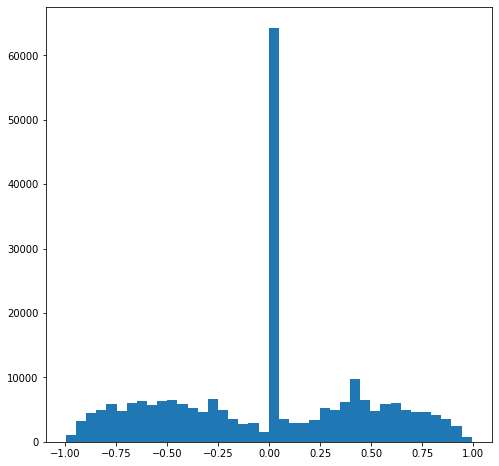

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8)) 
histo_plot = plt.hist(dfOriginals_Analyzed['compound'],bins=40)


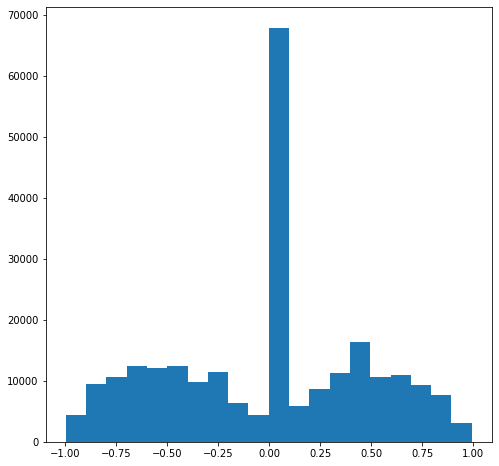

In [95]:
plt.figure(figsize=(8,8)) 
histo_plot2 = plt.hist(dfOriginals_Analyzed['compound'],bins=20)


(-1.1182944691568912,
 1.1129382929025038,
 -1.1162563432183583,
 1.1007741115818266)

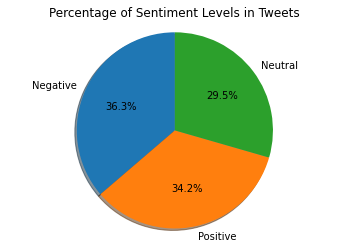

In [96]:
# Plot pie chart
# 

fig1, ax1 = plt.subplots()
ax1.pie(dfOriginals_Analyzed.sentiment_class_relaxed.value_counts().values, labels=dfOriginals_Analyzed.sentiment_class_relaxed.value_counts().index.rename_categories(['Negative','Neutral','Positive']), autopct='%1.1f%%', shadow=True, startangle=90)
ax1.title.set_text("Percentage of Sentiment Levels in Tweets")
ax1.axis('equal')

# Step 8. Build Prediction Model for "Favourite Count" with Linear Regression

## Split Train and Test set

In [229]:
from sklearn import preprocessing
from sklearn import linear_model



independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'favorite_count'


trainSet=dfOriginals_Analyzed.sample(frac=0.8,random_state=150)
testSet=dfOriginals_Analyzed.drop(trainSet.index)

X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]
reg = linear_model.LinearRegression()

reg.fit(X_train,Y_train)

print("Coefficients of the features in the model: " + ', '.join(independent_variables))
print(reg.coef_)
print("R-score for the training set: " + str(reg.score(X_train,Y_train)))
print("intercept of the regression model: " + str(reg.intercept_))


Coefficients of the features in the model: retweet_count, user_followers_count, compound, user_statuses_count, user_favourites_count, user_friends_count, user_listed_count
[ 2.53671317e+00  2.11072957e-04  1.01637608e+00 -3.78429955e-05
  5.74939172e-05 -5.59458026e-05 -3.45590885e-02]
R-score for the training set: 0.7998590370741462
intercept of the regression model: 1.9466913989873138


Since this is a regression model with continous values, we use Mean Square Error (MSE), Root MSE, and R-square metrics to measure the performance of the model. 

reference: https://stackoverflow.com/questions/49103139/calculating-accuracy-scores-of-predicted-continuous-values

In [230]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from math import sqrt

# Run prediction; Concating results onto a single dataframe; rounding prediction numbers as integer.
plot_1_Y = reg.predict(X_test) # predicted as Y
plot_1_X = Y_test.reset_index()  # actual as X
df_plot_1 = pd.concat([plot_1_X,pd.DataFrame(plot_1_Y)],axis=1)
df_plot_1.columns = ['index','actual', 'predicted']
df_plot_1.predicted = round(df_plot_1.predicted,0).astype(int)

mse = mean_squared_error(df_plot_1.actual, df_plot_1.predicted)
mae = mean_absolute_error(df_plot_1.actual, df_plot_1.predicted)
r2 = r2_score(df_plot_1.actual, df_plot_1.predicted)
adj_r2 = 1-(1-r2)*(len(df_plot_1.actual)-1)/(len(df_plot_1.actual)-len(independent_variables)-1)
print("\nMetrics\n============================================")
print(f"Mean Square Error (MSE): {mse:4f}")
print(f"Root MSE:\t\t {sqrt(mse):4f}")
print(f"Mean Absolute Error:\t {mae:4f}")
print(f"R-Square:\t\t {r2:4f}")
print(f"Adjusted R-Square:\t {adj_r2:4f}")




Metrics
Mean Square Error (MSE): 33404.189046
Root MSE:		 182.768129
Mean Absolute Error:	 7.281756
R-Square:		 0.873217
Adjusted R-Square:	 0.873199


Scatterplot to visually observe how well the model's prediction vs actual value.

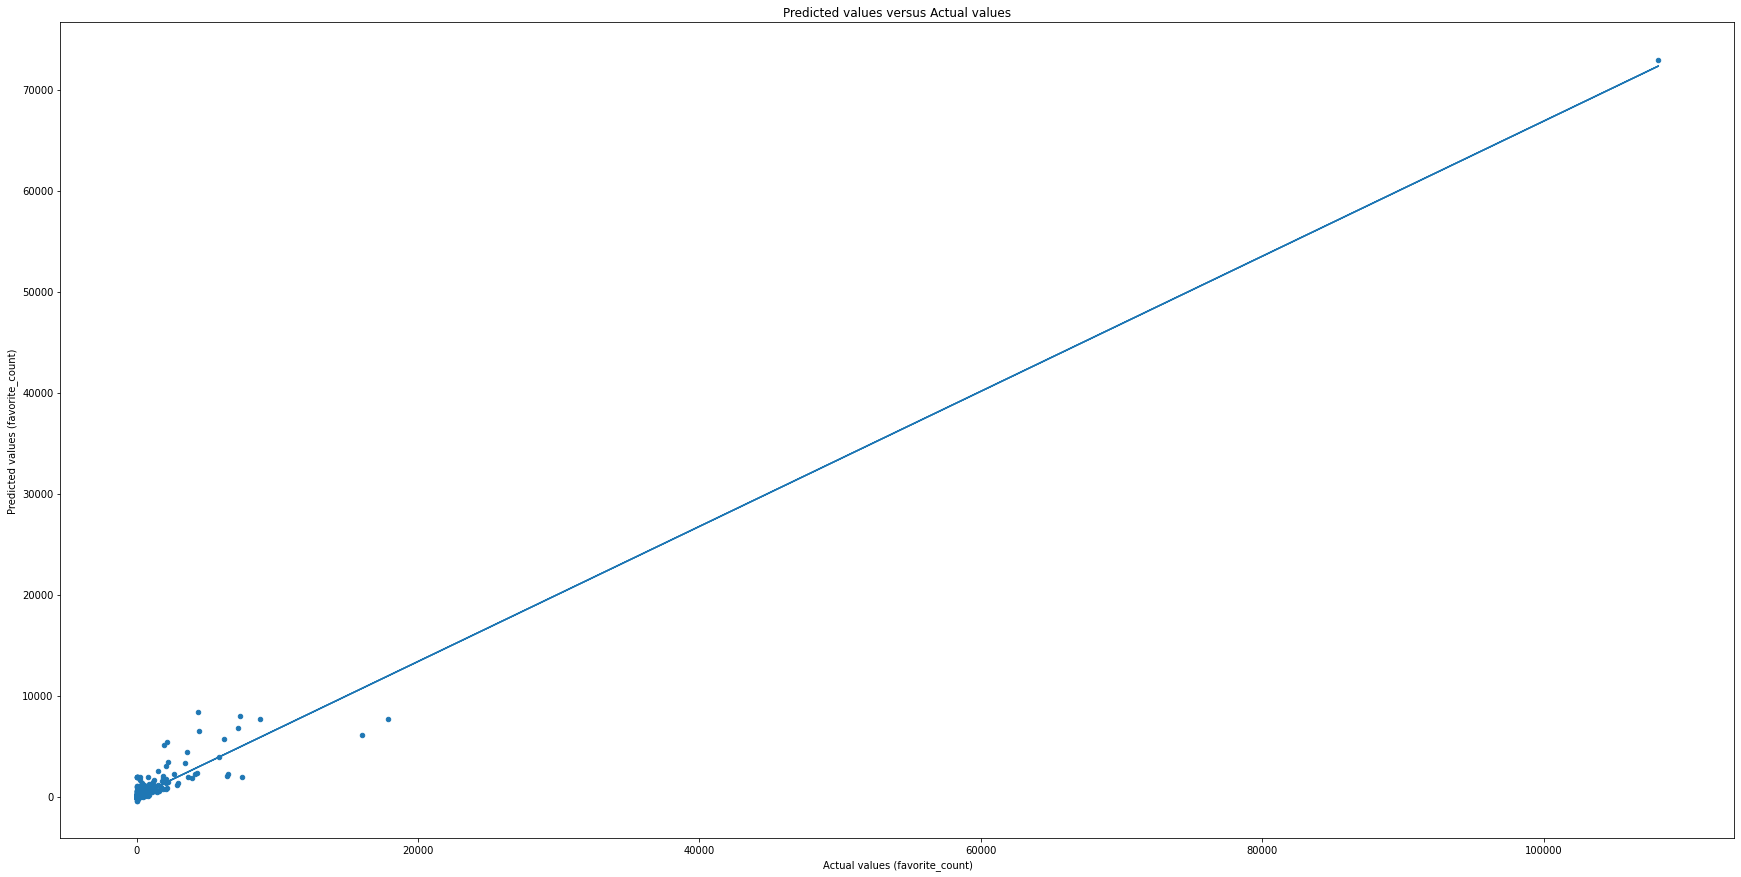

In [231]:
from numpy.polynomial.polynomial import polyfit

plot_1 = df_plot_1.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Predicted values versus Actual values")
plot_1.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_1.set_xlabel("Actual values (" + dependent_variables + ")")

b, m = polyfit(df_plot_1.actual, df_plot_1.predicted, 1)
plot_1.plot(df_plot_1.actual, b + m * df_plot_1.actual, '-')



Since our outliers are distorting the scatterplot visually, we will limit the observation to 2-sigma (95%).

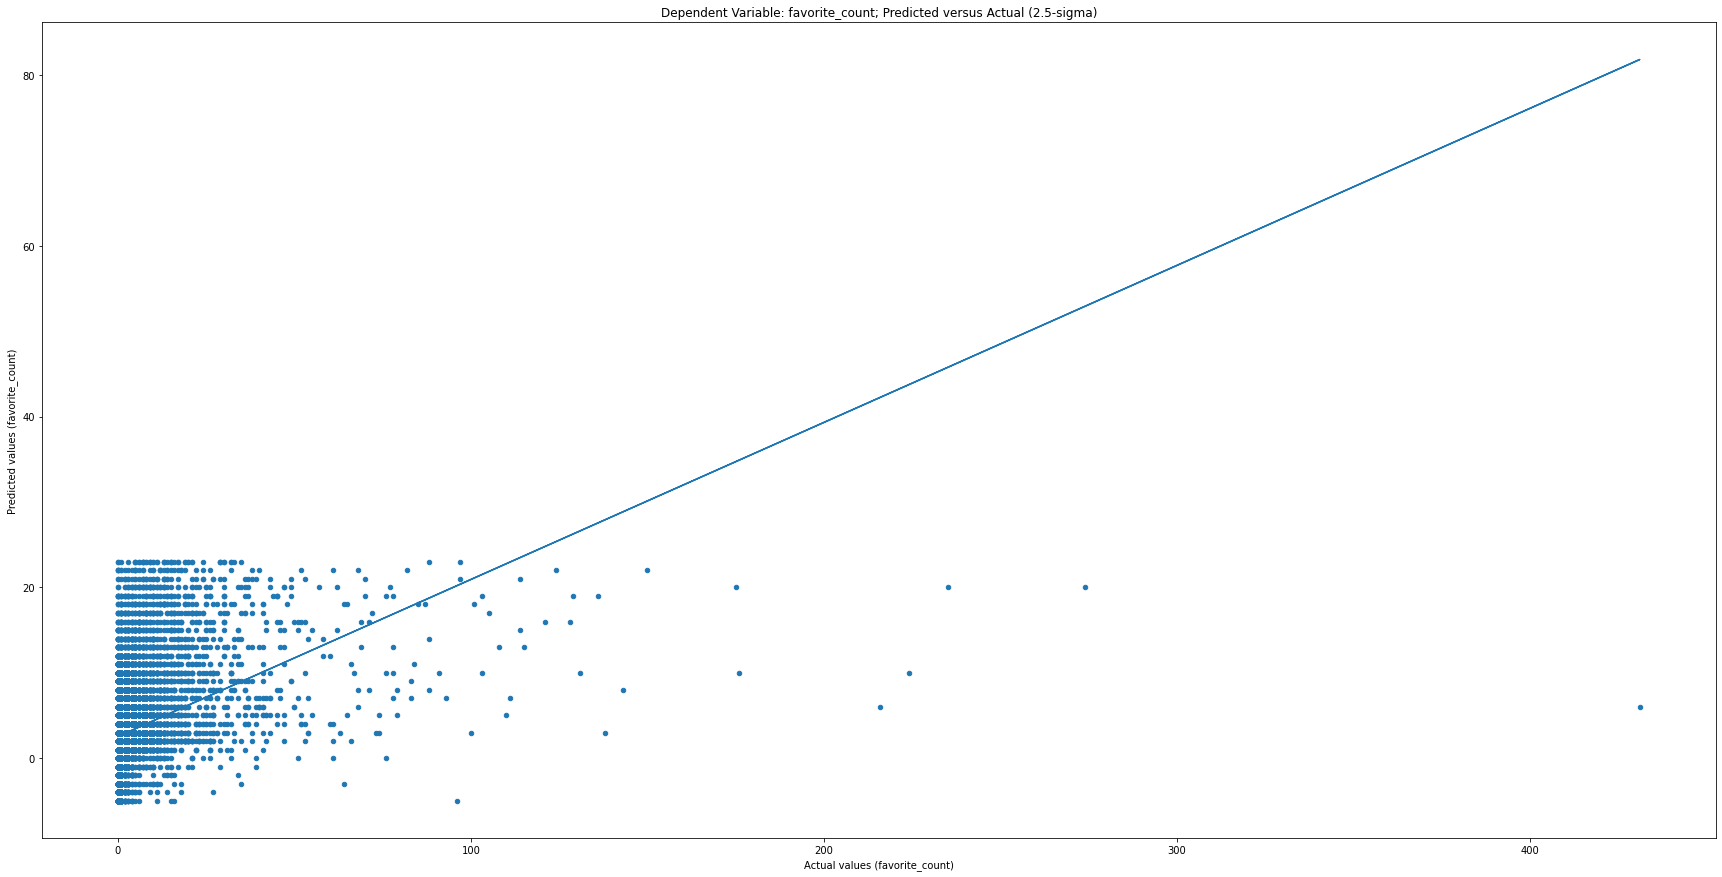

In [232]:
df_plot_2 = df_plot_1[df_plot_1.predicted.between(df_plot_1.predicted.quantile(0.025), df_plot_1.predicted.quantile(0.975))]
plot_2 = df_plot_2.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual (2.5-sigma)")
plot_2.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_2.set_xlabel("Actual values (" + dependent_variables + ")")
# plt.ylim([0,800])
# plt.xlim([0,1500])

b, m = polyfit(df_plot_2.actual, df_plot_2.predicted, 1)
plot_2.plot(df_plot_2.actual, b + m * df_plot_2.actual, '-')

# Step 9. Build Prediction Model for "Retweet Count" with Linear Regression

## Split Train and Test set

In [227]:
from sklearn import preprocessing
from sklearn import linear_model


# independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'favorite_count'

# independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'retweet_count'

trainSet=dfOriginals_Analyzed.sample(frac=0.8,random_state=150)
testSet=dfOriginals_Analyzed.drop(trainSet.index)

X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]
reg = linear_model.LinearRegression()

reg.fit(X_train,Y_train)

print("Coefficients: " + ', '.join(independent_variables))
print(reg.coef_)
print("R-score for the training set: " + str(reg.score(X_train,Y_train)))
print("intercept of the regression model: " + str(reg.intercept_))

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from math import sqrt

# Run prediction; Concating results onto a single dataframe; rounding prediction numbers as integer.
plot_1_Y = reg.predict(X_test) # predicted as Y
plot_1_X = Y_test.reset_index()  # actual as X
df_plot_1 = pd.concat([plot_1_X,pd.DataFrame(plot_1_Y)],axis=1)
df_plot_1.columns = ['index','actual', 'predicted']
df_plot_1.predicted = round(df_plot_1.predicted,0).astype(int)

# mse = mean_squared_error(df_plot_1.actual, df_plot_1.predicted)
# print("Mean Square Error (MSE): " + str(mse))
# print("Root MSE: " + str(sqrt(mse)))
# print("R-Square: " + str(r2_score(df_plot_1.actual, df_plot_1.predicted)))

mse = mean_squared_error(df_plot_1.actual, df_plot_1.predicted)
mae = mean_absolute_error(df_plot_1.actual, df_plot_1.predicted)
r2 = r2_score(df_plot_1.actual, df_plot_1.predicted)
adj_r2 = 1-(1-r2)*(len(df_plot_1.actual)-1)/(len(df_plot_1.actual)-len(independent_variables)-1)
print("\nMetrics\n============================================")
print(f"Mean Square Error (MSE): {mse:4f}")
print(f"Root MSE:\t\t {sqrt(mse):4f}")
print(f"Mean Absolute Error:\t {mae:4f}")
print(f"R-Square:\t\t {r2:4f}")
print(f"Adjusted R-Square:\t {adj_r2:4f}")


Coefficients: favorite_count, user_followers_count, compound, user_statuses_count, user_favourites_count, user_friends_count, user_listed_count
[ 3.11235360e-01 -5.45113705e-05 -4.49341154e-01  1.31140200e-05
 -1.42531031e-05  2.52704569e-05  9.86068817e-03]
R-score for the training set: 0.7918817593018982
intercept of the regression model: -0.22477642853551627

Metrics
Mean Square Error (MSE): 1234.588084
Root MSE:		 35.136706
Mean Absolute Error:	 1.967480
R-Square:		 0.934187
Adjusted R-Square:	 0.934178


In [222]:
type(independent_variables)
coefficient_list = (list(zip(reg.coef_, independent_variables)))
for el in coefficient_list:
  print('{}\t\t\t{}'.format(*el))
# print("\n".join('{}\t{}'.format(el) for el in coefficient_list))


0.31123535955149645			favorite_count
-5.451137053005906e-05			user_followers_count
-0.4493411537915842			compound
1.3114020026653957e-05			user_statuses_count
-1.425310311562202e-05			user_favourites_count
2.527045685125415e-05			user_friends_count
0.009860688166209995			user_listed_count


Scatterplot of Predicted value vs Actual Value.

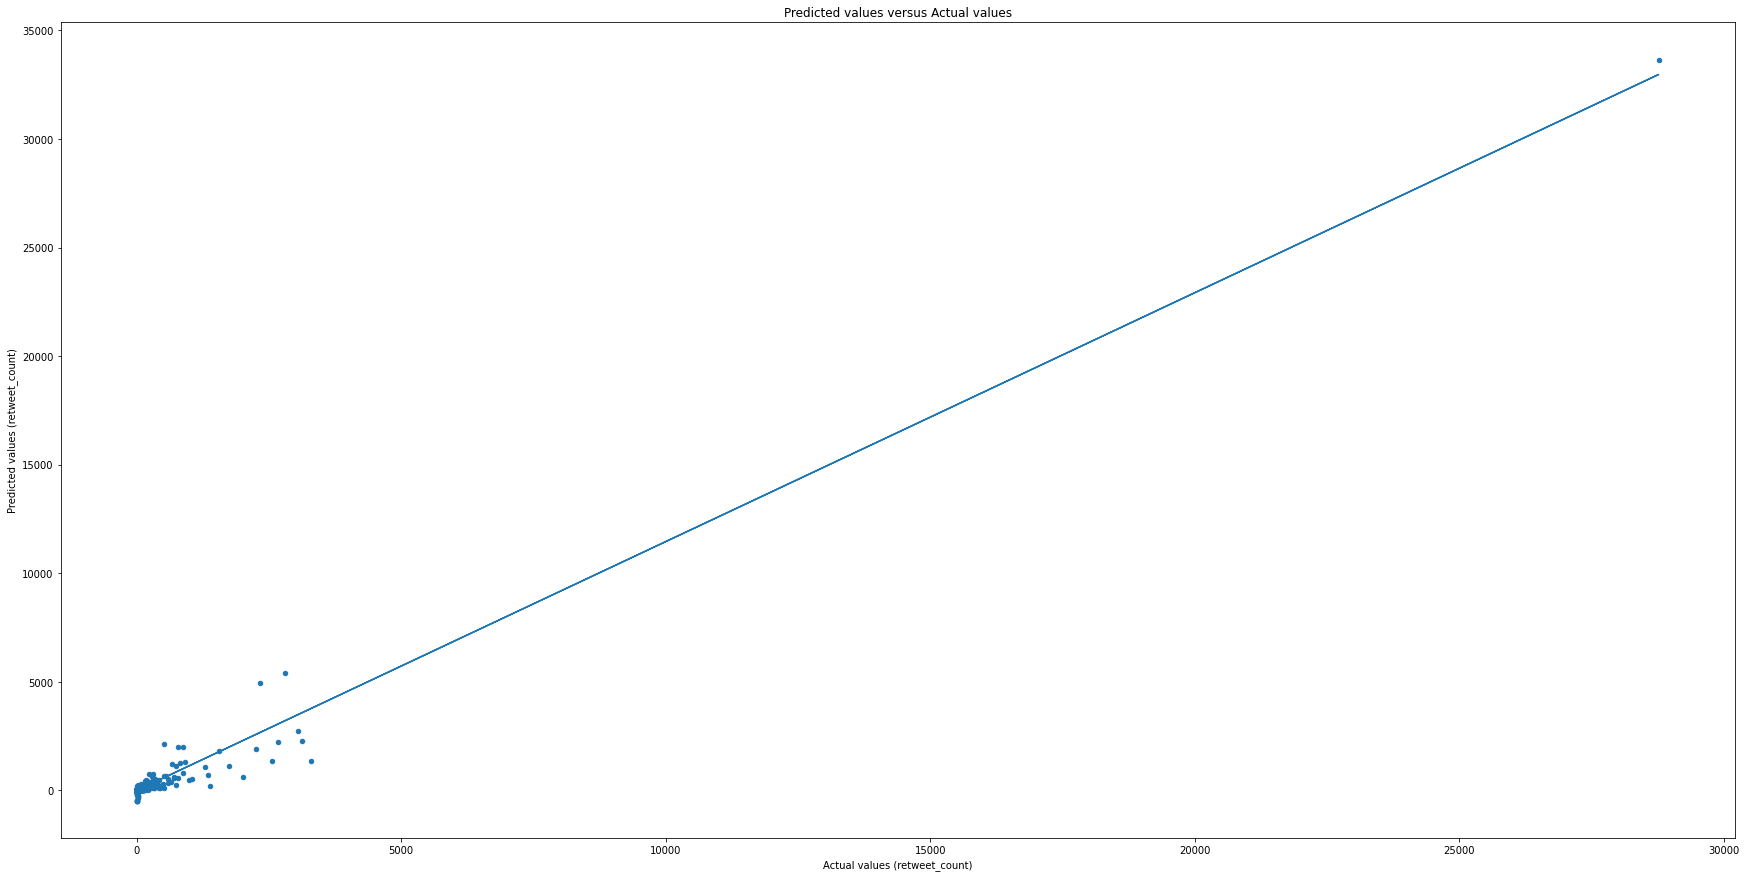

In [223]:
from numpy.polynomial.polynomial import polyfit

plot_1 = df_plot_1.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Predicted values versus Actual values")
plot_1.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_1.set_xlabel("Actual values (" + dependent_variables + ")")

b, m = polyfit(df_plot_1.actual, df_plot_1.predicted, 1)
plot_1.plot(df_plot_1.actual, b + m * df_plot_1.actual, '-')



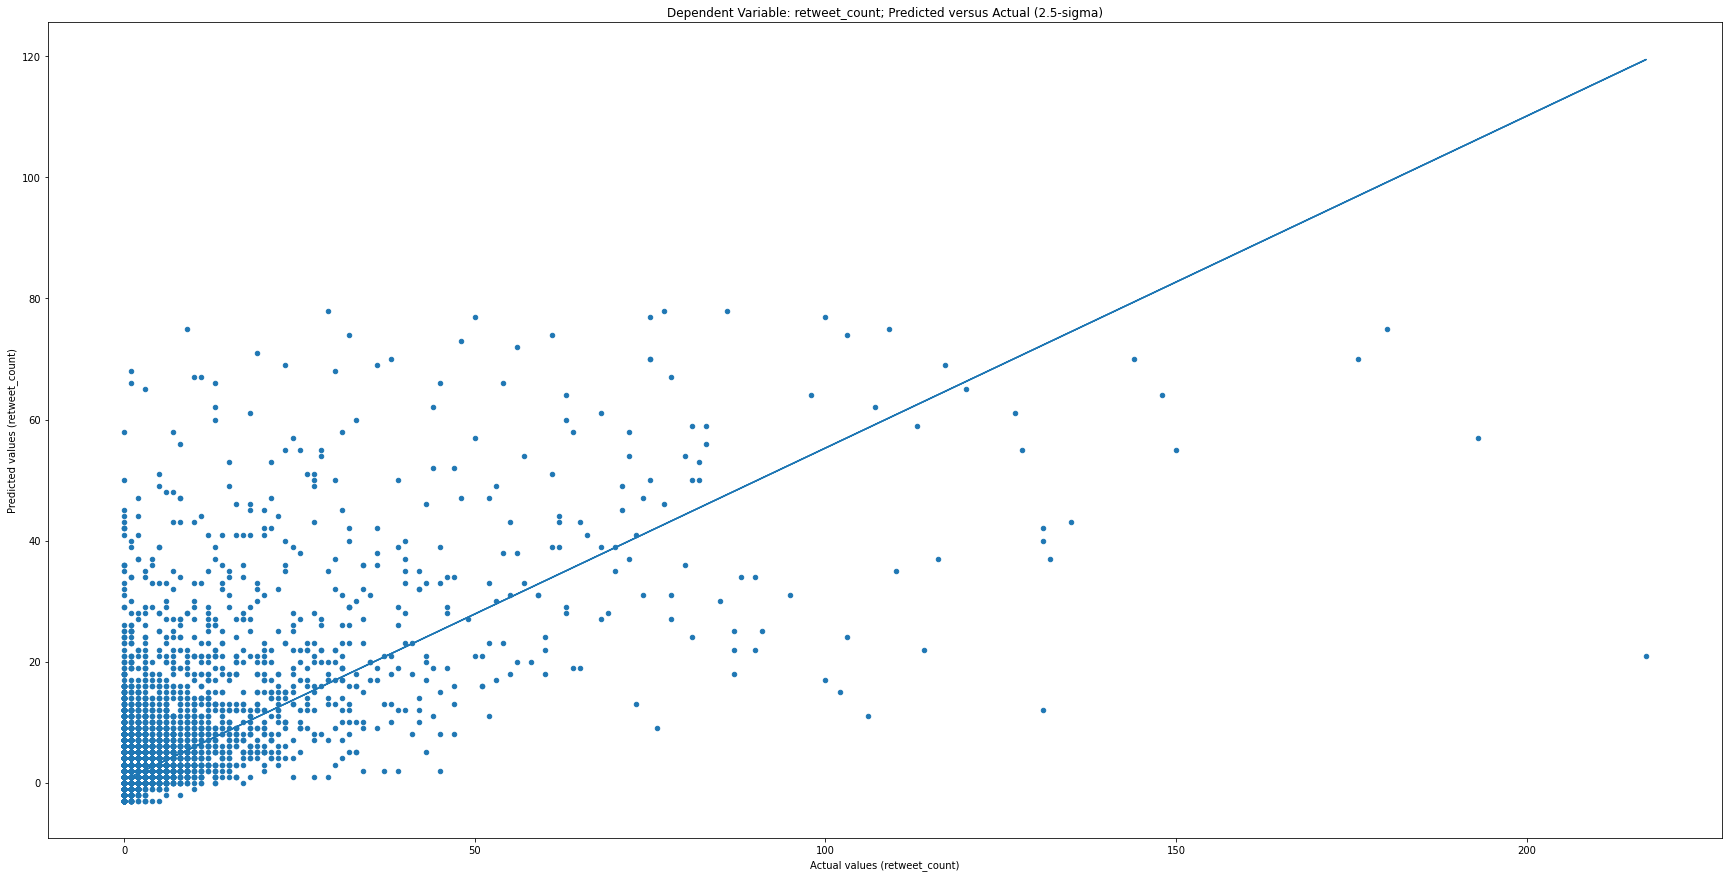

In [224]:
# Scatterplot covering 2.5-sigma.
df_plot_2 = df_plot_1[df_plot_1.predicted.between(df_plot_1.predicted.quantile(.0031), df_plot_1.predicted.quantile(0.9969))]
plot_2 = df_plot_2.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual (2.5-sigma)")
plot_2.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_2.set_xlabel("Actual values (" + dependent_variables + ")")

b, m = polyfit(df_plot_2.actual, df_plot_2.predicted, 1)
plot_2.plot(df_plot_2.actual, b + m * df_plot_2.actual, '-')

# Step 10: Linear Regression with K-fold

Since the metrics we got from the previous regression consist of only one sampling, we should implement the same regression model using K-fold cross-validation in order to get more accurate metrics.

In [178]:
# K-fold - favourite count as dependent
#
# References:
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
# https://stackoverflow.com/questions/57398411/next-always-gives-the-same-index-with-a-kfold-generator
# https://machinelearningmastery.com/k-fold-cross-validation/
# https://machinelearningmastery.com/robust-regression-for-machine-learning-in-python/
from sklearn.model_selection import KFold

independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'favorite_count'
# independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_followers_count','user_friends_count','user_listed_count']
# dependent_variables = 'retweet_count'

kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = 0, 0, 0;
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

# Excluding outliers, only including within 3-sigma
# dfKfold = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfKfold = dfOriginals_Analyzed

kf_result = kf.split(dfKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("Mean Square Error (MSE)\t\tRoot MSE\t\t\tR-Square\n=============================================================================================")

for train_idx, test_idx in kf_result:
  # print(train_idx)
  trainSet=dfKfold.iloc[train_idx]
  testSet=dfKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  reg.fit(X_train,Y_train)

  y_test_pred = reg.predict(X_test) 

  mse = mean_squared_error(Y_test, y_test_pred)
  rsqr = r2_score(Y_test, y_test_pred)
  # print("Mean Square Error (MSE): " + str(mse))
  # print("Root MSE: " + str(sqrt(mse)))
  # print("R-Square: " + )

  print("{}\t\t{}\t\t{}".format(str(mse), str(sqrt(mse)), str(rsqr)))

  kfold_mse_total += mse
  kfold_rmse_total += sqrt(mse)
  kfold_rsqr_total += rsqr

print("\nAverage\n=============================================================================================")
print("{}\t\t{}\t\t{}".format(
    str(kfold_mse_total / kfold_n) , \
    str(kfold_rmse_total / kfold_n) , \
    str(kfold_rsqr_total / kfold_n) \
    ))




Dependent Variable: favorite_count
Independent Variables: ['retweet_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_favourites_count', 'user_friends_count', 'user_listed_count']
K-fold: 5
Mean Square Error (MSE)		Root MSE			R-Square
31564.218170437452		177.66321558059636		0.8778246081673832
10521.044828406117		102.57214450525112		0.7048723199591314
130028.32915673508		360.5944108783927		0.3781302906838815
10211.723621891868		101.05307329266076		0.7828323162685373
13119.346895412113		114.53971754554013		0.9302006642072554

Average
39088.932534576525		171.28451236048824		0.7347720398572377


In [179]:
# K-fold Retweet as independent
#

from sklearn.model_selection import KFold

# independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_followers_count','user_friends_count','user_listed_count']
# dependent_variables = 'favorite_count'
independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_followers_count','user_friends_count','user_listed_count']
dependent_variables = 'retweet_count'

kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = 0, 0, 0;
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

# Excluding outliers, only including within 3-sigma
# dfKfold = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfKfold = dfOriginals_Analyzed

kf_result = kf.split(dfKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("Mean Square Error (MSE)\t\tRoot MSE\t\t\tR-Square\n=============================================================================================")

for train_idx, test_idx in kf_result:
  # print(train_idx)
  trainSet=dfKfold.iloc[train_idx]
  testSet=dfKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  reg.fit(X_train,Y_train)

  y_test_pred = reg.predict(X_test) 

  mse = mean_squared_error(Y_test, y_test_pred)
  rsqr = r2_score(Y_test, y_test_pred)
  # print("Mean Square Error (MSE): " + str(mse))
  # print("Root MSE: " + str(sqrt(mse)))
  # print("R-Square: " + )

  print("{}\t\t{}\t\t{}".format(str(mse), str(sqrt(mse)), str(rsqr)))

  kfold_mse_total += mse
  kfold_rmse_total += sqrt(mse)
  kfold_rsqr_total += rsqr

print("\nAverage\n=============================================================================================")
print("{}\t\t{}\t\t{}".format(
    str(kfold_mse_total / kfold_n) , \
    str(kfold_rmse_total / kfold_n) , \
    str(kfold_rsqr_total / kfold_n) \
    ))




Dependent Variable: retweet_count
Independent Variables: ['favorite_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_favourites_count', 'user_followers_count', 'user_friends_count', 'user_listed_count']
K-fold: 5
Mean Square Error (MSE)		Root MSE			R-Square
1000.9845872116636		31.638340462351426		0.9455950041720176
798.1113842383231		28.250865194509053		0.6053632599185065
10974.758803865681		104.76048302611859		0.6853190833192548
726.6329948665574		26.95613093280557		0.7512550861124329
668.976723248869		25.86458434324567		0.9595497944916513

Average
2833.8928986862184		43.49408079180606		0.7894164456027726


# Step 11: Polynomial Regression

Here we attempt to fit our model onto a non-linear regression model--Polynomial regression model to see whether we are able to build a better fit of the model than linear regression.

R-squared values: 

Polynomial degree 1: test score=0.87
Polynomial degree 2: test score=0.72
Polynomial degree 3: test score=-5.57
Polynomial degree 6: test score=0.11


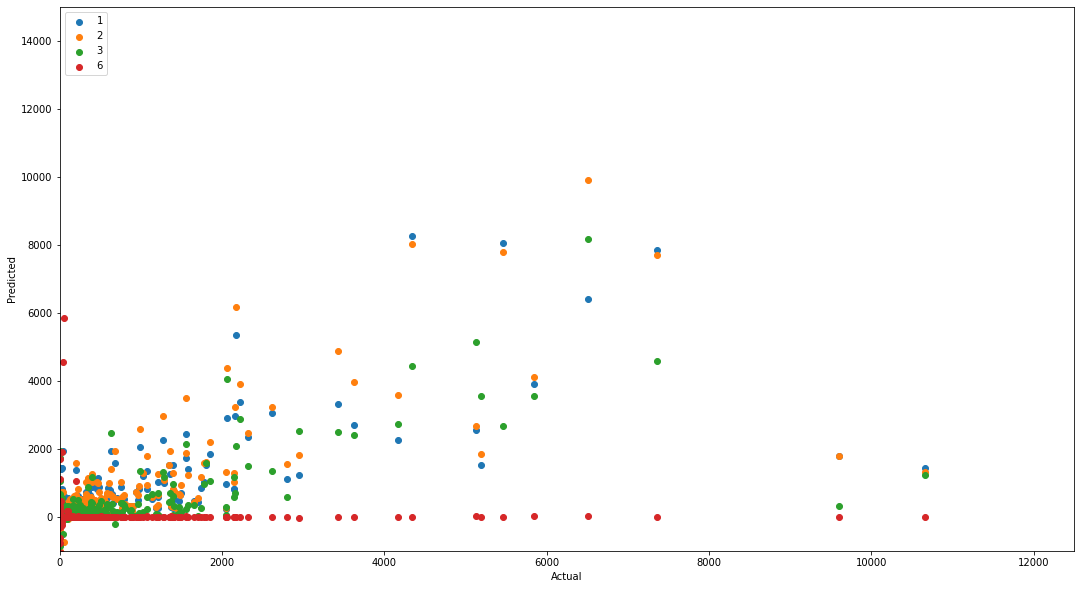

In [180]:
# POLYNOMIAL REGRESSION #1 favorite_count
#
#
# Reference
# https://www.kaggle.com/jnikhilsai/cross-validation-with-linear-regression

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'favorite_count'
# independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'retweet_count'
degrees = [1, 2, 3, 6]

# excluding Outliners
# dfPoly = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfPoly = dfOriginals_Analyzed

trainSet=dfPoly.sample(frac=0.8,random_state=200)
testSet=dfPoly.drop(trainSet.index)


X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]

# y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

# calculate values for each degree
for i, degree in enumerate(degrees):    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    # y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)
  
# plot the graph
plt.figure(figsize=(40, 10))
plt.subplot(121)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.ylim([-1000,15000])
plt.xlim([0,12500])
for i, degree in enumerate(degrees):    
    plt.scatter(Y_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')


# print metrics
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    # train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: test score={1}".format(degree, test_r2))

R-squared values: 

Polynomial degree 1: test score=0.94
Polynomial degree 2: test score=0.08
Polynomial degree 3: test score=0.01
Polynomial degree 6: test score=-422.7


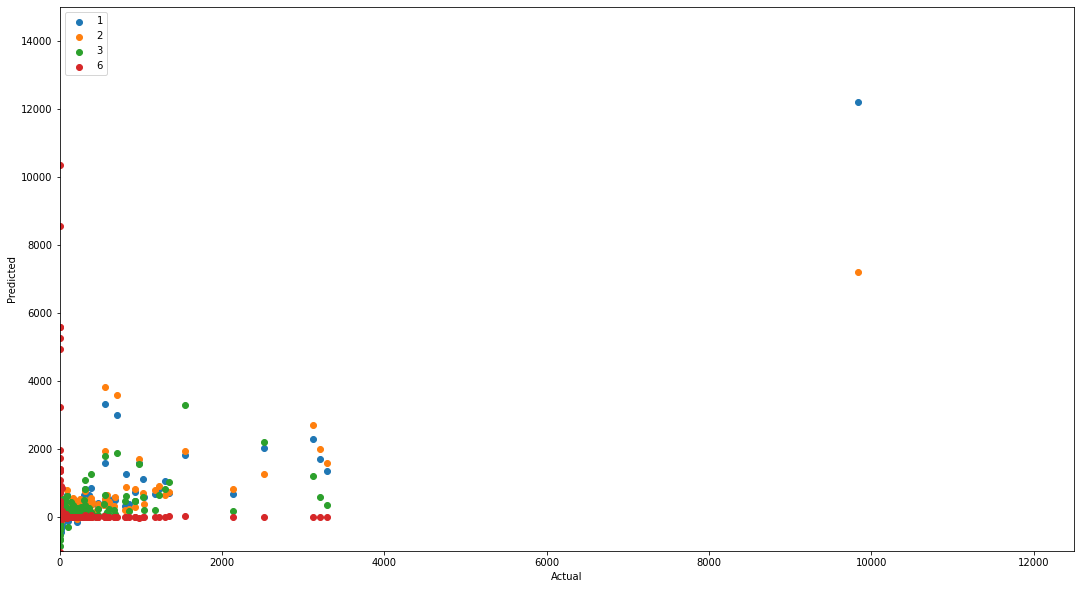

In [181]:
# POLYNOMIAL REGRESSION #2 retweet_count
#


import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'favorite_count'
independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'retweet_count'
degrees = [1, 2, 3, 6]

# excluding Outliners
# dfPoly = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfPoly = dfOriginals_Analyzed

trainSet=dfPoly.sample(frac=0.8,random_state=200)
testSet=dfPoly.drop(trainSet.index)


X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]

# y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

# calculate values for each degree
for i, degree in enumerate(degrees):    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    # y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)
  
# plot the graph
plt.figure(figsize=(40, 10))
plt.subplot(121)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.ylim([-1000,15000])
plt.xlim([0,12500])
for i, degree in enumerate(degrees):    
    plt.scatter(Y_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')


# print metrics
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    # train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: test score={1}".format(degree, test_r2))

# Further Attempts

- Groupby user_screen_name
- calculate the mean sentiment score
- see whether there are any correlation between number of followers and number of favourite tweets against the mean sentimental score (check SD)

explain properly an understanding of why introducing new feature

In [182]:
dfOriginals.groupby('user_screen_name').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

,user_screen_name,counts
27508,ELister_social,666
79905,SattarSarki1,382
133777,iHeartFun1,185
27433,EG24NEWS,181
142347,kailashscienti1,179
...,...,...
68494,Patterico,1
68495,PattheOldBat,1
68496,PattiClifford10,1
68498,PattiMurin,1


## Notes from last meeting
is final results due next monday

[link text](https://)
* is the level of detailness enough for the steps?
* any metrics i still need?
* is next week's due date include the presentation?
* is there any specific dates to when the presentation will be.
* updated plot, outlier
* update graph to exclude
* have linear model, but also run another non-linear model
* set xlim and ylim
* removing outlier using SD central tendencies (or visual 3 SD away)
* - non linear regression
* - scale x and y axis
* polynomial regression models
* word doc make reference 